# Bayes Rule - events

$$\mathbf P(A \mid B) = \frac{\mathbf P(A~\mathrm{and}~B)}{\mathbf P(B)} = \frac{\mathbf P(B \mid A) \mathbf P(A)}{\mathbf P(B)} = \frac{\mathbf P(B \mid A) \mathbf P(A)}{\mathbf P(B \mid A) \mathbf P(A) + \mathbf P(B \mid \mathrm{not}~A) \mathbf P(\mathrm{not}~A)}$$

In [1]:
def prob_a_given_b(prob_b_given_a, prob_b_given_not_a, prob_a):
    
    # P(A) + P(not A) = 1
    prob_not_a = 1 - prob_a

    # P(A and B) = P(B | A) P(A)
    prob_b_and_a = prob_b_given_a * prob_a

    # P(not A, and B) = P(B | not A) P(not A)
    prob_b_and_not_a = prob_b_given_not_a * prob_not_a

    # P(B) = P(B and A) + P(B and not A) <-- compare to first line...
    prob_b = prob_b_and_a + prob_b_and_not_a

    # P(A | B) = P(A and B) / P(B)
    prob_a_given_b = prob_b_and_a / prob_b
    
    return prob_a_given_b

## 1. Positive tests

In [2]:
# A is "Has COVID-25"
# B is "Gave a positive test"

print("Probability of having COVID having given a positive test = ", 
      prob_a_given_b(
        prob_b_given_a = 0.95, # Probability of a positive test if you have COVID
        prob_b_given_not_a = 0.01, # Probability of a positive test if you don't have COVID
        prob_a = 0.001 # Underlying probability of having COVID
      )
     )

Probability of having COVID having given a positive test =  0.08683729433272395


The analysis above is far more subtle in real life. In the problem statement I never mentioned *symptoms*. Yes, with mandated tests you might say that the person being tested has been drawn from the population at large. But when a person decides to test because they have symptoms, it's going to be totally different. We're not randomly drawing from the population any more. This problem is known as selection bias: https://www.nature.com/articles/s41564-021-01029-0

## 2. Problematic stakeholders

In [3]:
# A is "Conversion has increased"
# B is "We have observed increased sales"

print("Evidence of increased sales means stakeholder thinks chance of increased conversion is ", 
prob_a_given_b(
    prob_b_given_a = 0.9, # Probability of increased sales with the increased conversion
    prob_b_given_not_a = 0.01, # Probability of increased sales arising without the increased conversion
    prob_a = 0.01 # Stakeholder's subjective judgement of the probability that we have increased conversion
))

Evidence of increased sales means stakeholder thinks chance of increased conversion is  0.4761904761904762


# Bayes Rule - random variables

$$\mathbf P(X = x \mid Y = y) = \frac{\mathbf P(X = x~\mathrm{and}~Y = y)}{\mathbf P(Y = y)} = \frac{\mathbf P(Y=y \mid X=x) \mathbf P(X = x)}{\mathbf P(Y = y)} = \frac{\mathbf P(Y = y \mid X = x) \mathbf P(X = x)}{\sum_\xi \mathbf P(Y = y \mid X = \xi) \mathbf P(X = \xi)}$$

In [4]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import beta

In [48]:
# Prior parameters
_alpha = 2
_beta = 1

# Experiment
batch_size = 10
observed_defects = 0

model = pm.Model()
with model:
    X = pm.Beta("defect_rate", alpha=_alpha, beta=_beta)
    Y = pm.Binomial("observed_defects", n = batch_size, p = X, observed = observed_defects)

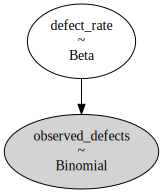

In [49]:
model.to_graphviz()

In [50]:
with model:
    idata = pm.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


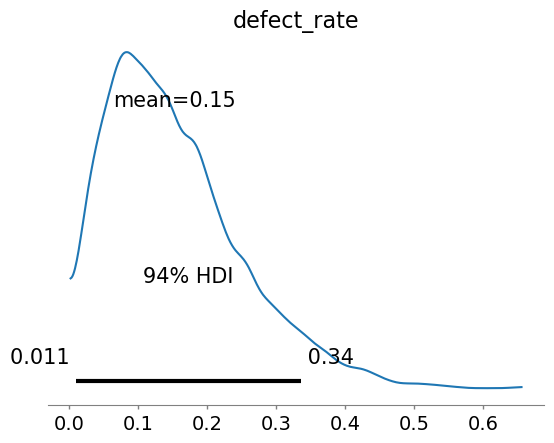

In [51]:
fig = az.plot_posterior(idata)
plt.show()

In [52]:
import numpy as np

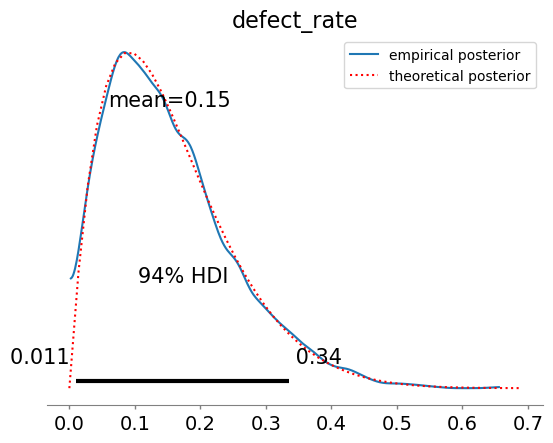

In [53]:
az.plot_posterior(idata, label='empirical posterior')
theoretical_posterior = beta(_alpha + observed_defects, _beta + batch_size - observed_defects)
unit_interval = np.linspace(0, fig.get_xlim()[1])
plt.plot(unit_interval, theoretical_posterior.pdf(unit_interval), color='red', linestyle=':', label='theoretical posterior')
plt.legend()
plt.show()

Can't get this working: trying to think about false positives and false negatives

In [60]:
prob_will_flag_defect_as_defect = 0.98
prob_will_flag_good_as_defect = 0.01

model_with_error = pm.Model()
with model_with_error:
    X = pm.Beta("defect_rate", alpha=_alpha, beta=_beta)
    Y = pm.Binomial("latent_defects", n = batch_size, p = X)
    Z_tp = pm.Binomial("true_positives", n = Y, p = prob_will_flag_defect_as_defect)
    Z_fp = pm.Binomial("false_positives", n = batch_size-Y, p = prob_will_flag_good_as_defect)
    Z = pm.Deterministic("observed_defects", Z_tp + Z_fp)


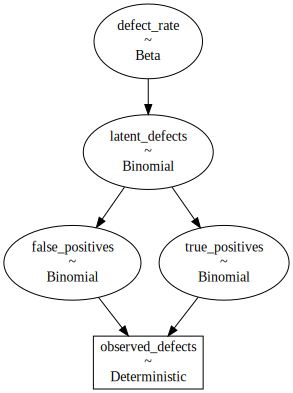

In [61]:
model_with_error.to_graphviz()

In [56]:
with model_with_error:
    idata_with_error = pm.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


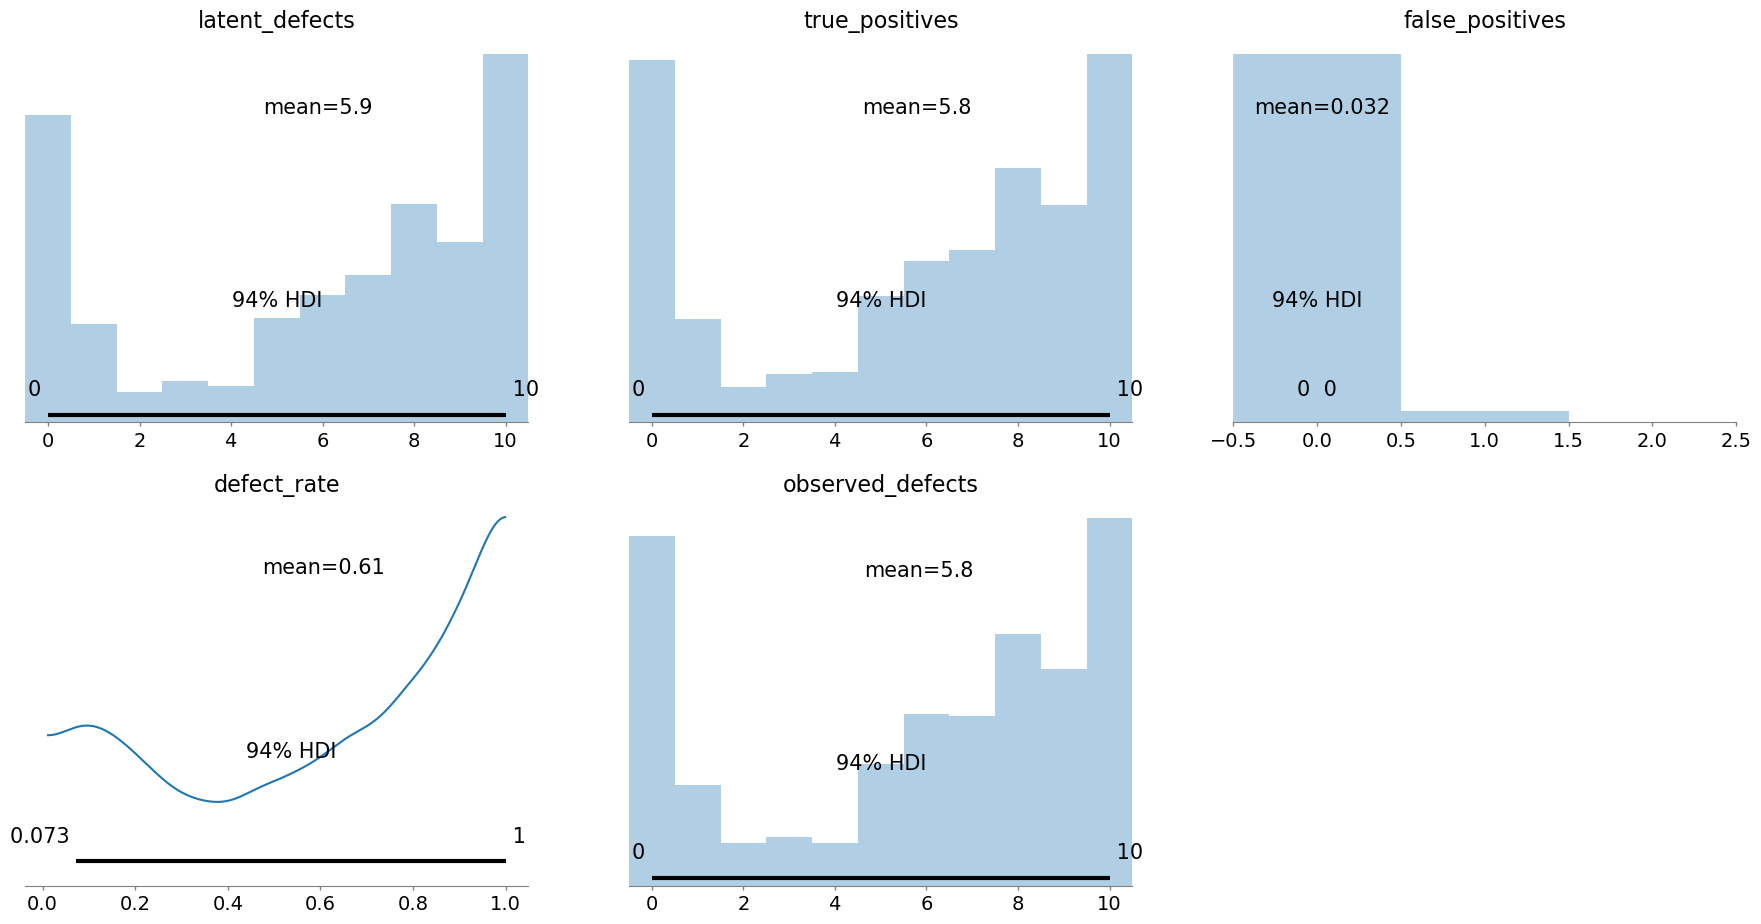

In [59]:
fig = az.plot_posterior(idata_with_error)
plt.show()